# VAE on MNIST

This is for Question (f) of the assignment. I need it to be tidy, so I can experiment with it.

## Imports

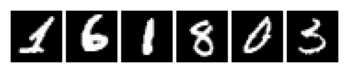

In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision

import random

mnist = torchvision.datasets.MNIST(
    root = 'pytorch-data/',  # where to put the files
    download = True,         # if files aren't here, download them
    train = True,            # whether to import the test or the train subset
    # PyTorch uses PyTorch tensors internally, not numpy arrays, so convert them.
    transform = torchvision.transforms.ToTensor()
)

# Images can be plotted with matplotlib imshow
show = [mnist[i] for i in [59289, 28001, 35508, 43876, 23627, 14028]]
show = torch.stack([img for img,lbl in show])
x = torchvision.utils.make_grid(show, nrow=6, pad_value=1)
plt.imshow(x.numpy().transpose((1,2,0)))
plt.axis('off')
plt.show()

mnist_batched = torch.utils.data.DataLoader(mnist, batch_size=100)

# Models

## Simple d-dimensional VAE

In [3]:
class BernoulliImageGenerator(nn.Module):
    def __init__(self, d=4):
        super().__init__()
        self.d = d
        self.f = nn.Sequential(
            nn.Linear(d, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1728),
            nn.LeakyReLU(),
            nn.Unflatten(1, (12,12,12)), # -> B×12×12×12
            nn.Conv2d(12, 36, 3, 1),     # -> [B×36×10×10]
            nn.LeakyReLU(),
            nn.Flatten(1),               # -> [B×3600]
            nn.Unflatten(1, (4,30,30)),  # -> [B×4×30×30]
            nn.Conv2d(4, 4, 3, 1),       # -> [B×4×28×28]
            nn.LeakyReLU(),
            nn.Conv2d(4, 1, 1, 1),       # -> [B×1×28×28]
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.f(z)

    def loglik(self, x, z):
        xr = self(z)
        return (x*torch.log(xr) + (1-x)*torch.log(1-xr)).sum((1,2,3))


class GaussianEncoder(nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.d = decoder.d
        self.f = decoder
        self.g = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.Linear(9216, 128),
            nn.LeakyReLU(),
            nn.Linear(128, self.d*2)
        )

    def forward(self, x):
        μτ = self.g(x)
        μ,τ = μτ[:,:self.d], μτ[:,self.d:]
        return μ, torch.exp(τ/2)

    def loglik_lb(self, x):
        μ,σ = self(x)
        kl = 0.5 * (μ**2 + σ**2 - torch.log(σ**2) - 1).sum(1)
        ε = torch.randn_like(σ)
        ll = self.f.loglik(x, z=μ+σ*ε)
        return ll - kl

## Expanded sampling d-dimensional VAE

In [4]:
class BernoulliImageGeneratorExpandedSampling(nn.Module):
    def __init__(self, d=4):
        super().__init__()
        self.d = d
        self.f = nn.Sequential(
            nn.Linear(d, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1728),
            nn.LeakyReLU(),
            nn.Unflatten(1, (12,12,12)), # -> B×12×12×12
            nn.Conv2d(12, 36, 3, 1),     # -> [B×36×10×10]
            nn.LeakyReLU(),
            nn.Flatten(1),               # -> [B×3600]
            nn.Unflatten(1, (4,30,30)),  # -> [B×4×30×30]
            nn.Conv2d(4, 4, 3, 1),       # -> [B×4×28×28]
            nn.LeakyReLU(),
            nn.Conv2d(4, 1, 1, 1),       # -> [B×1×28×28]
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.f(z)

    def loglik(self, x, z):
      """ When this is called, the argument z is the value that a random variable Z takes on.
          It's a bit confusing, because z is actually a vector of z_i that random variables Z_i take on.
          This equates to the likelihood of each x_i under a particular choice of z - one sample. To take
          multiple samples, we need to try multiple values of little z, which happens when this is called."""
      xr = self(z)
      return (x*torch.log(xr) + (1-x)*torch.log(1-xr)).sum((1, 2, 3))


class GaussianEncoderExpandedSampling(nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.d = decoder.d
        self.f = decoder
        self.g = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.Linear(9216, 128),
            nn.LeakyReLU(),
            nn.Linear(128, self.d*2)
        )
        self.max_likelihood = (0, 0)
        self.min_likelihood = (0, 0)

    def forward(self, x):
        μτ = self.g(x)
        μ,τ = μτ[:,:self.d], μτ[:,self.d:]
        return μ, torch.exp(τ/2)

    def loglik_lb(self, batch_num, x):
        μ,σ = self(x)
        kl = 0.5 * (μ**2 + σ**2 - torch.log(σ**2) - 1).sum(1)

        # Running the below is equivalent to sampling just once
        # a value for Z(phi, x) for each of the data poitns in the
        # vector x. If we want multiple samples, we don't need to
        # pass through the encoder again - that will be the same,
        # given the parameters we have now. But if we sample the
        # noise epsilon again, we'll get a different Z(phi, x).
        ll = 0
        num_samples = 1
        for _ in range(num_samples):
          ε = torch.randn_like(σ)
          ll += self.f.loglik(x, z=μ+σ*ε)
        ll /= num_samples

        if torch.min(ll) < self.min_likelihood[0]:
          self.min_likelihood = torch.min(ll), torch.argmin(ll) + batch_num*100

        if torch.max(ll) < self.max_likelihood[0]:
          self.max_likelihood = torch.max(ll), torch.argmax(ll) + batch_num*100

        # Sum up all likelihoods to find likelihood of dataset.
        return ll - kl

## VAE with image-label pairs as input

In [3]:
def one_hot_encode(y, num_classes):
    encoded = torch.zeros(len(y), num_classes)
    for i in range(len(y)):
        encoded[i, y[i]-1] = 1
    return encoded

In [10]:
class BernoulliImageGeneratorWithStyleCapture(nn.Module):
    def __init__(self, d=4):
        super().__init__()
        self.d = d
        self.f = nn.Sequential(
            nn.Linear(d + 10, 128),           # TODO: this is where we would have d + num_classes
            nn.LeakyReLU(),
            nn.Linear(128, 1728),
            nn.LeakyReLU(),
            nn.Unflatten(1, (12,12,12)), # -> B×12×12×12
            nn.Conv2d(12, 36, 3, 1),     # -> [B×36×10×10]
            nn.LeakyReLU(),
            nn.Flatten(1),               # -> [B×3600]
            nn.Unflatten(1, (4,30,30)),  # -> [B×4×30×30]
            nn.Conv2d(4, 4, 3, 1),       # -> [B×4×28×28]
            nn.LeakyReLU(),
            nn.Conv2d(4, 1, 1, 1),       # -> [B×1×28×28]
            nn.Sigmoid()
        )

    def forward(self, z, y):
        # Coerce z and y into a shape that we can feed to the network.
        # z is 100x4, y is 100x10

        z = torch.cat([z, y], dim=1)
        
        return self.f(z)

    def loglik(self, x, z, y):
        xr = self(z, y)
        return (x*torch.log(xr) + (1-x)*torch.log(1-xr)).sum((1,2,3))


class GaussianEncoderWithStyleCapture(nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.d = decoder.d
        self.f = decoder
        self.g = nn.Sequential(
            nn.Conv2d(2, 32, 3, 1),          # There are now two channels to account for the added label.
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.Linear(9216, 128),
            nn.LeakyReLU(),
            nn.Linear(128, self.d*2)
        )

    def forward(self, x, y):
        
        # TODO: Coerce x and y into a form that we can input into the network.
        # Encode y as a 1x28x28, then stack it as an extra channel in the image.
        # So updated y is 100x1x28x28.
        transform_labels = nn.Linear(10, 784)
        
        y_transformed = [transform_labels(y_i) for y_i in y]
        y_transformed = torch.tensor([y_i.view(1, 28, 28).detach().numpy() for y_i in y_transformed]) # Reshaped to Bx1x28x28. Do I need to unsqueeze here given y is already batched?
        
        x = torch.cat([x, y_transformed], dim=1)
        
        mu_tau = self.g(x)
        mu, tau = mu_tau[:,:self.d], mu_tau[:,self.d:]
        return mu, torch.exp(tau/2)

    def loglik_lb(self, x, y):
        """x is 100x1x28x28. y is 100x10 (one-hot encoded class labels)"""
        
        mu, sigma = self(x, y)
        
        kl = 0.5 * (mu**2 + sigma**2 - torch.log(sigma**2) - 1).sum(1)
        
        # Sampling from epsilon is equivalent to generating multiple Z~.
        epsilon = torch.randn_like(sigma)
        z = mu + sigma*epsilon
        
        ll = self.f.loglik(x, z, y)
        return ll - kl

In [4]:
autoencoder = GaussianEncoderWithStyleCapture(BernoulliImageGeneratorWithStyleCapture(4))
optimizer = optim.Adam(autoencoder.parameters())
epoch = 0

while epoch < 10:
    for batch_num, (images, labels) in enumerate(mnist_batched):
        optimizer.zero_grad()
        labels = one_hot_encode(labels, 10)
        loglik_lb = torch.mean(autoencoder.loglik_lb(images, labels))
        (-loglik_lb).backward()
        optimizer.step()
    epoch += 1
    print(f"epoch: {epoch}, loglikelihood: {loglik_lb.item():.4}")

epoch: 1, loglikelihood: -145.5
epoch: 2, loglikelihood: -135.0
epoch: 3, loglikelihood: -127.8
epoch: 4, loglikelihood: -124.5
epoch: 5, loglikelihood: -121.4


KeyboardInterrupt: 

# Helper functions

## Save a model

In [5]:
torch.save(autoencoder.state_dict(), 'cvae.pt')

## Load a saved model

In [27]:
simple_vae = GaussianEncoder(BernoulliImageGenerator())
simple_vae.load_state_dict(torch.load("4-dim-100-epoch.pt"))

<All keys matched successfully>

## Generate a random sample

In [55]:
z = torch.randn(4).unsqueeze(1).T
y = [8]
y_t = one_hot_encode(y, 10)

rec_image = autoencoder.f(z, y_t).detach().numpy()

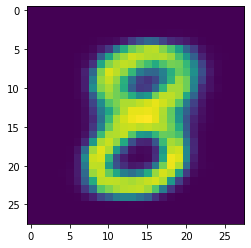

In [56]:
plt.imshow(rec_image[0][0])

In [89]:
img, lbl = mnist[random.randrange(0, len(mnist))]

print(lbl)

# Need to reshape to (1, 1, 28, 28) because this VAE works on batches.
mu, sigma = autoencoder(img.reshape((1, 1, 28, 28))) 
z = mu + sigma * torch.randn_like(sigma)

gen_img = simple_vae.f(z)

1


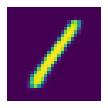

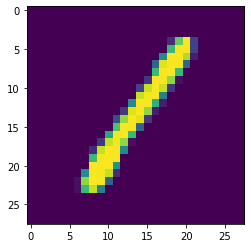

In [90]:
fig = plt.figure(figsize=(10, 10))
plot_images(fig, gen_img)
plt.imshow(img[0])

## Plot multiple images

In [40]:
def plot_images(fig, images):
    images = [image.detach().numpy()[0] for image in images]
    for i in range(len(images)):
        fig.add_subplot(5, 5, i+1)
        plt.imshow(images[i])
        
    plt.axis('off')
    plt.show()

In [6]:
z = torch.randn((100, 4))

z.shape

torch.Size([100, 4])

In [32]:
y = torch.floor(torch.rand((100,))*10)
y = torch.unsqueeze(y, 1)

In [11]:
torch.cat([z, y], dim=1)

RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [14]:
y

tensor([5., 0., 5., 5., 5., 7., 5., 9., 5., 0., 7., 9., 9., 3., 0., 1., 6., 2.,
        0., 8., 9., 0., 6., 8., 8., 3., 7., 1., 6., 9., 5., 6., 2., 8., 9., 4.,
        2., 2., 9., 9., 0., 3., 2., 7., 0., 9., 3., 8., 8., 9., 1., 1., 0., 9.,
        6., 0., 6., 3., 5., 9., 5., 2., 8., 2., 1., 8., 6., 9., 3., 6., 7., 3.,
        8., 3., 1., 1., 5., 8., 3., 4., 1., 3., 9., 5., 1., 3., 7., 8., 9., 8.,
        7., 5., 2., 6., 9., 1., 8., 0., 0., 2.])

In [33]:
lin = nn.Linear(1, 4)

In [38]:
res = torch.tensor([lin(y_i).detach().numpy() for y_i in y])

res

tensor([[ 0.5049,  1.7098,  1.8893, -1.0040],
        [ 0.5049,  1.7098,  1.8893, -1.0040],
        [ 2.4840,  5.4759,  6.3077, -4.3866],
        [ 1.6924,  3.9695,  4.5404, -3.0336],
        [ 2.4840,  5.4759,  6.3077, -4.3866],
        [ 0.1090,  0.9566,  1.0057, -0.3274],
        [ 3.2757,  6.9823,  8.0751, -5.7397],
        [ 1.6924,  3.9695,  4.5404, -3.0336],
        [ 2.0882,  4.7227,  5.4240, -3.7101],
        [ 2.8799,  6.2291,  7.1914, -5.0632],
        [ 0.9007,  2.4630,  2.7730, -1.6805],
        [ 3.2757,  6.9823,  8.0751, -5.7397],
        [ 2.4840,  5.4759,  6.3077, -4.3866],
        [ 3.2757,  6.9823,  8.0751, -5.7397],
        [ 2.8799,  6.2291,  7.1914, -5.0632],
        [ 2.8799,  6.2291,  7.1914, -5.0632],
        [ 0.9007,  2.4630,  2.7730, -1.6805],
        [ 2.8799,  6.2291,  7.1914, -5.0632],
        [ 1.6924,  3.9695,  4.5404, -3.0336],
        [ 3.2757,  6.9823,  8.0751, -5.7397],
        [ 2.8799,  6.2291,  7.1914, -5.0632],
        [ 0.5049,  1.7098,  1.8893